In [1]:
# default_exp gan.learner

# gan.learner

> API details.

In [2]:
# export

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm import tqdm
from fastrenewables.synthetic_data import *
from fastrenewables.gan.model import *
from fastrenewables.tabular.model import EmbeddingModule

#import glob

In [3]:
# export

class GANLearner():
    def __init__(self, gan, n_gen=1, n_dis=1):
        super(GANLearner, self).__init__()
        # gan should contain a class which itself contains a generator and discriminator/critic class and combines them
        self.gan = gan
        self.n_gen = n_gen
        self.n_dis = n_dis
   
    def generate_samples(self, x_cat, x_cont):
        z = self.gan.noise(x_cont)
        fake_samples = self.gan.generator(x_cat, z).detach()
        return fake_samples
    
    def fit(self, dl, epochs=10, plot_epochs=10, save_model=False):
        
        self.gan.to_device(self.gan.device)
        for e in tqdm(range(epochs)):
            for x_cat, x_cont, y in dl:
                x_cat = x_cat.to(self.gan.device).long()
                x_cont = x_cont.to(self.gan.device)
                y = y.to(self.gan.device)
                                
                for _ in range(self.n_dis):
                    self.gan.train_discriminator(x_cat, x_cont, y)

                for _ in range(self.n_gen):
                    self.gan.train_generator(x_cat, x_cont, y)
                
            if (e+1)%plot_epochs==0:
                plt.figure(figsize=(16, 9))
                plt.plot(self.gan.real_loss, label='Real Loss')
                plt.plot(self.gan.fake_loss, label='Fake Loss')
                plt.legend()
                plt.show()
        
        if save_model:
            self.gan.to_device('cpu')
        
        return

### Examples:

GAN(
  (generator): GANMLP(
    (embedding_module): EmbeddingModule(
      (embeddings): ModuleList(
        (0): Embedding(3, 3)
      )
    )
    (model): Sequential(
      (0): Sequential(
        (0): Linear(in_features=103, out_features=64, bias=True)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): Sequential(
        (0): Linear(in_features=64, out_features=1, bias=True)
        (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (3): Sigmoid()
    )
  )
  (discriminator): AuxiliaryDiscriminator(
    (basic_discriminator): GANMLP(
      (model): Sequential(
        (0): Sequential(
          (0): Linear(in_features=1, out_features=64, bias=True)
  

 90%|█████████ | 9/10 [00:02<00:00,  5.00it/s]

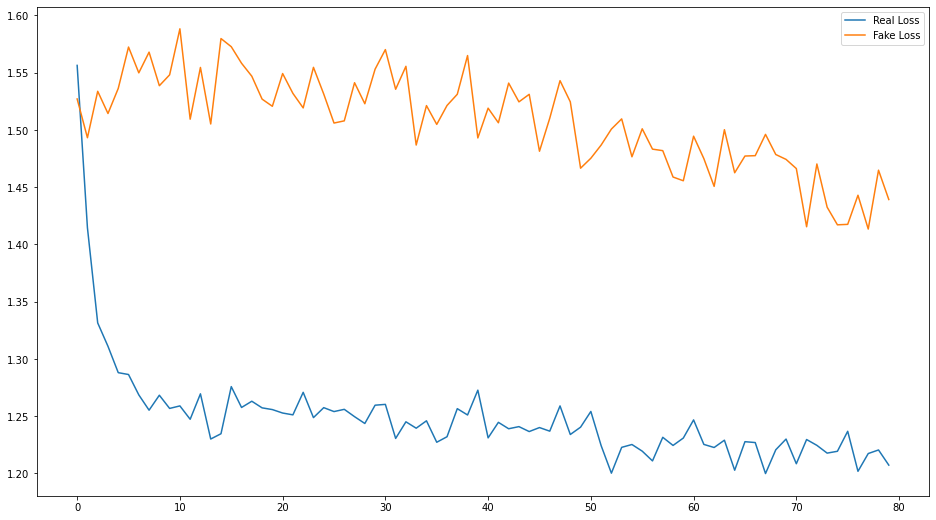

100%|██████████| 10/10 [00:02<00:00,  3.75it/s]


In [4]:
n_samples = 1024
n_classes = 2
n_features = 1
batch_size = 256
n_z = 100
n_in = n_features
n_hidden = 64
epochs = 10
n_gen = 1
n_dis = 1

data = GaussianDataset(n_samples, n_classes)
dl = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)

emb = EmbeddingModule(categorical_dimensions=[n_classes+1])

model = get_gan_model(gan_type='aux', structure=[n_z, n_hidden, n_hidden, n_in], n_classes=2, emb_module=emb, bn=True)
print(model)

learner = GANLearner(gan=model, n_gen=n_gen, n_dis=n_dis)
learner.fit(dl, epochs=epochs, plot_epochs=epochs)

# Tests:

distribution of real data:


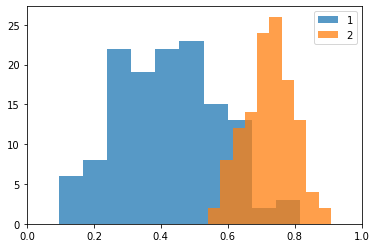

distribution of generated data:


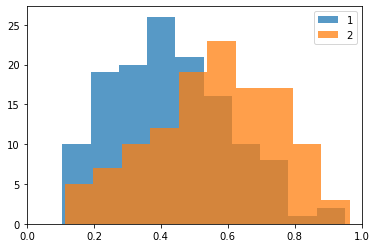

In [5]:
for x_cat, x_cont, y in dl:
    x_fake = learner.generate_samples(x_cat.long().cuda(), x_cont.cuda()).cuda()

    print('distribution of real data:')
    plot_class_hists(x_cat.cpu(), x_cont.cpu())

    print('distribution of generated data:')
    plot_class_hists(x_cat.cpu(), x_fake.cpu().detach())
    break